In [1]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving an soft matrix reinforced with a hard fiber. It is subjected to uniform normal traction under a plane-stress condition.

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './MatrixFiberRVE.med')

Loaded SALOME .med mesh: 817 nodes, 988 elements
Node groups (4): ['left_e', 'right_e', 'top_e', 'bottom_e']
Element groups (7): ['all', 'fiber_s', 'matrix_s', 'bottom_e', 'top_e', 'right_e', 'left_e']


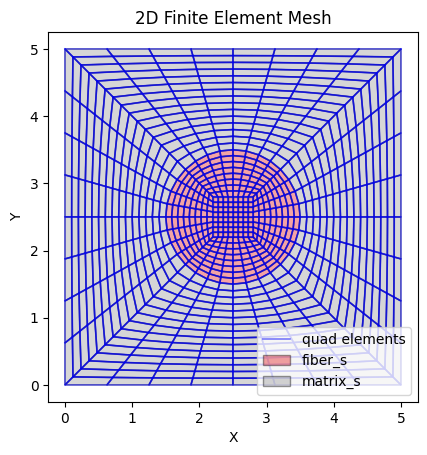

In [4]:
mesh.plot(show_nodes=False, element_groups_to_plot=['fiber_s','matrix_s'])

### Dirichlet boundary conditions

In [5]:
from feinn_solver import BoundaryCondition

bcs = {
        'left_e': [BoundaryCondition(dof=1, value=0.0),
                BoundaryCondition(dof=2, value=0.0)]             
        }

### Define material

In [6]:
from matmodels import LinearElastic

soft = LinearElastic(emod = 1, nu = 0.30)
hard = LinearElastic(emod = 10, nu = 0.30)

matfield = {'matrix_s': soft, 
            'fiber_s': hard}

### von Neumman boundary conditions

In [7]:
from feinn_solver import LineLoad

traction = {
            'right_e': LineLoad(fx = .10, fy = 0, reference = "global"),
            }


### Model

In [8]:
from feinn_solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      line_loads = traction,
                      verbose = True
                      )



[matfld] Assigned: ['matrix_s', 'fiber_s']
[matfld] All 988 elements have assigned material
[line_load] Applied 1 line load groups
[BC] Processed 2 Dirichlet condition(s) → 18 total constraint(s)
[BC] Applied Dirichlet BCs → 18 fixed DOFs


In [9]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 1.10e-13  Energetic error: 2.15e-15
Iter   2 | du error: 4.29e-14  Res error: 3.33e-14  Energetic error: -9.56e-31
Converged in 2 iterations


In [10]:
fem_solver.udisp

tensor([0.1611, 0.0031, 0.0000,  ..., 0.0011, 0.1717, 0.0011])

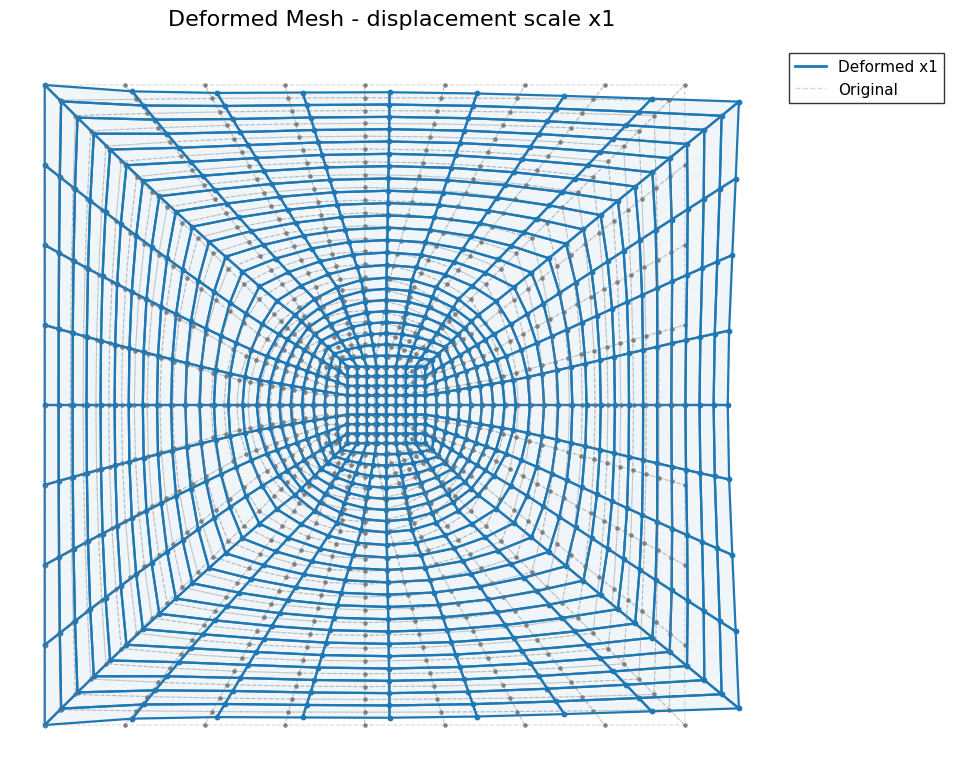

In [11]:
fem_solver.plot_deformed_mesh(scale=1)

In [12]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    line_loads = traction,
    verbose=False,
    nnet = mFCNet(num_layers=6, num_neurons=64),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

In [13]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 5000
cfg.learning_rate = 1e-3
cfg.lr_min = 1e-5

In [14]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   lbfgs_epochs = 50,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
Warmup loss: 1.85e-04
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 8.23e-02

Epoch 1/5000
Total Loss: 6.066e+02
  Domain: 7.844e+00
  BC:     5.987e+02

Epoch 500/5000
Total Loss: 2.458e+00
  Domain: 2.296e+00
  BC:     1.618e-01

Epoch 1000/5000
Total Loss: 1.136e+00
  Domain: 1.106e+00
  BC:     2.999e-02

Epoch 1500/5000
Total Loss: 7.910e+01
  Domain: 7.208e-01
  BC:     7.838e+01

Epoch 2000/5000
Total Loss: 5.332e-01
  Domain: 5.187e-01
  BC:     1.454e-02

Epoch 2500/5000
Total Loss: 4.259e-01
  Domain: 4.191e-01
  BC:     6.783e-03

Epoch 3000/5000
Total Loss: 4.592e-01
  Domain: 3.565e-01
  BC:     1.027e-01

Epoch 3500/5000
Total Loss: 3.212e-01
  Domain: 3.065e-01
  BC:     1.471e-02

Epoch 4000/5000
Total Loss: 3.834e-01
  Domain: 2.688e-01
  BC:     1.146e-01

Epoch 4500/5000
Total Loss: 4.279e-01
  Domain: 2.388e-01
  BC:     1.890e-01

Epoch 5000/5000
Total Loss: 7.686e+00

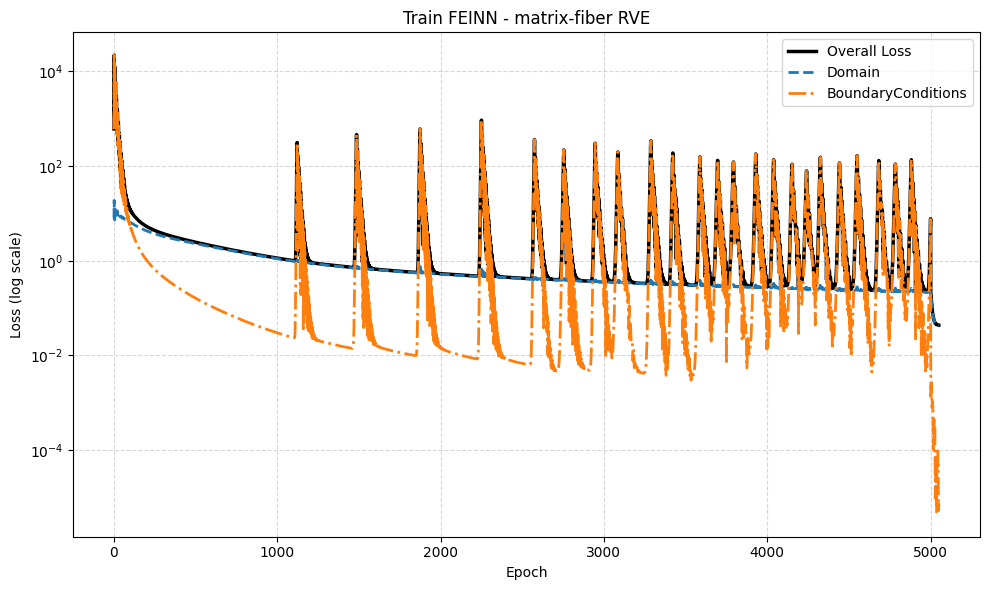

In [15]:
feinn_solver.plot_history(title="Train FEINN - matrix-fiber RVE")

In [18]:
# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   lbfgs_epochs = 50,
                   warmup = False, 
                   verbose = True)


Epoch 1/5000
Total Loss: 4.346e-02
  Domain: 4.345e-02
  BC:     7.856e-06

Epoch 500/5000
Total Loss: 1.154e-01
  Domain: 4.547e-02
  BC:     6.992e-02

Epoch 1000/5000
Total Loss: 2.769e+01
  Domain: 5.254e-02
  BC:     2.764e+01

Epoch 1500/5000
Total Loss: 1.050e+01
  Domain: 5.622e-02
  BC:     1.045e+01

Epoch 2000/5000
Total Loss: 1.143e-01
  Domain: 5.155e-02
  BC:     6.278e-02

Epoch 2500/5000
Total Loss: 6.779e-02
  Domain: 5.372e-02
  BC:     1.407e-02

Epoch 3000/5000
Total Loss: 5.338e-01
  Domain: 5.620e-02
  BC:     4.776e-01

Epoch 3500/5000
Total Loss: 1.011e+02
  Domain: 8.111e-02
  BC:     1.010e+02

Epoch 4000/5000
Total Loss: 1.130e+01
  Domain: 6.181e-02
  BC:     1.123e+01

Epoch 4500/5000
Total Loss: 9.862e-01
  Domain: 5.641e-02
  BC:     9.298e-01

Epoch 5000/5000
Total Loss: 4.868e-01
  Domain: 5.691e-02
  BC:     4.298e-01

Epoch 1/50 (L-BFGS)
Total Loss: 8.264e-02
  Domain: 6.651e-02
  BC:     1.612e-02

Epoch 10/50 (L-BFGS)
Total Loss: 4.753e-02
  Domain

C:\GitHub\CEIA\feinn_project\src\evaluator.py:36: RuntimeWarning: divide by zero encountered in divide
  100 * np.abs((self.y_pred - self.y_true) / self.y_true),


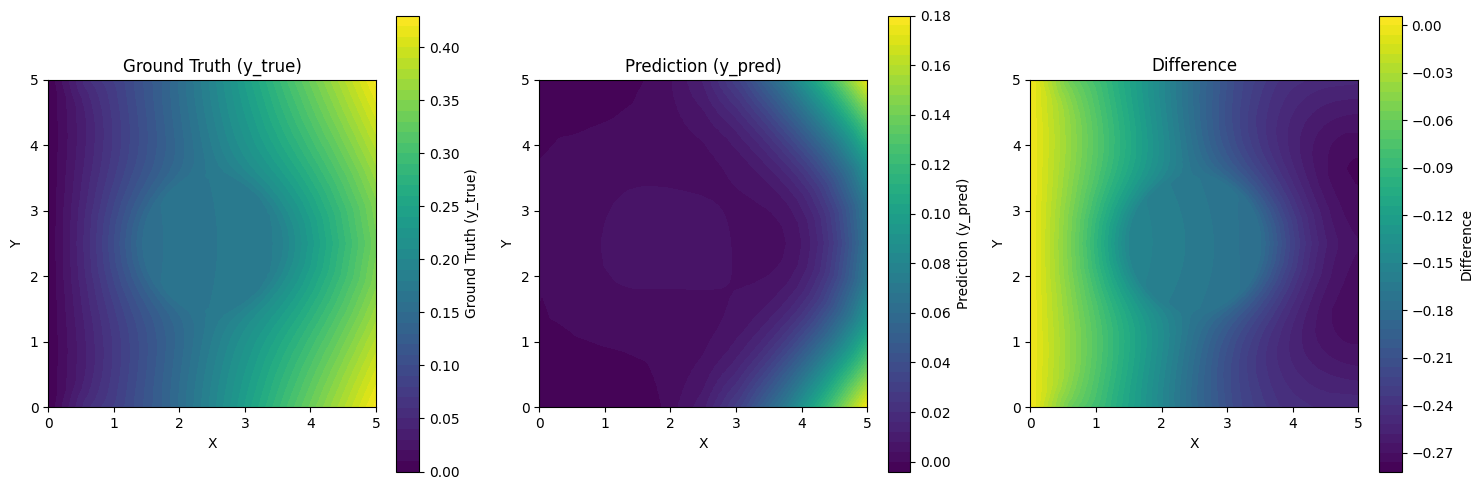

In [16]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

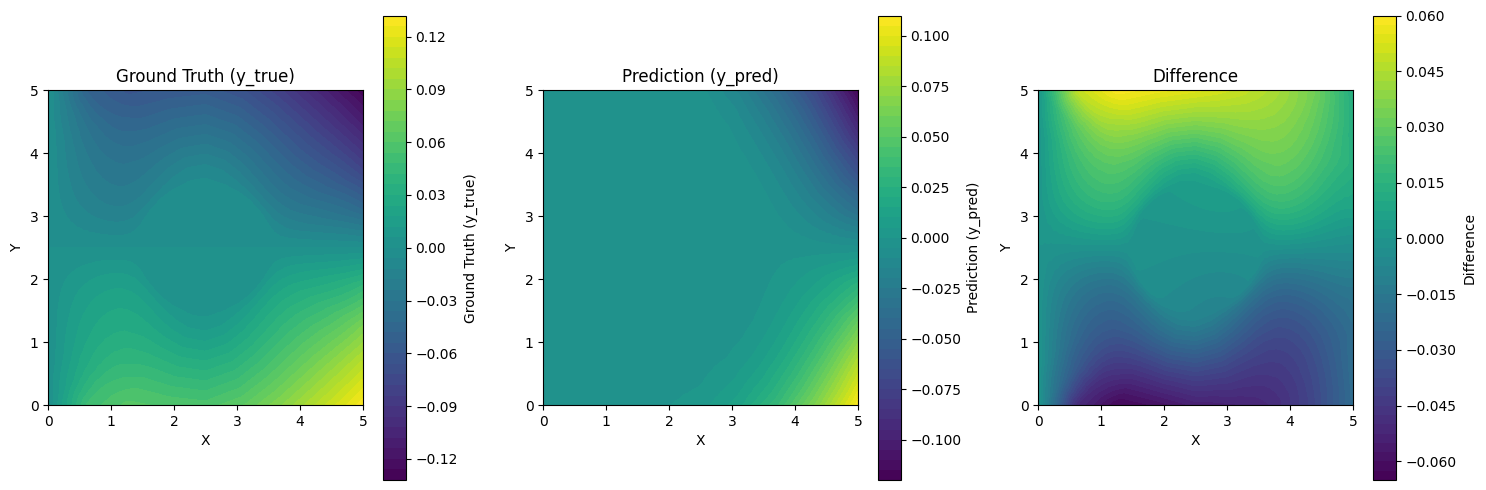

In [17]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')